In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 

ds = xr.open_dataset("results.nc") 

def field_da(da, field):
    return xr.DataArray(
        da.data[field],  
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs,
    )

compound = [name for name, da in ds.data_vars.items() if da.dtype.fields]

for name in compound:
    da = ds[name]
    ds[f"{name}_real"] = field_da(da, "r")
    ds[f"{name}_imag"] = field_da(da, "i")
    ds = ds.drop_vars(name)

df = ds.to_dataframe()   
df.to_csv('resources/diffraction_data.csv')

In [2]:
df = pd.read_csv('resources/diffraction_data.csv')
df

,omega,radiating_dof,influenced_dof,wave_direction,added_mass,radiation_damping,diffraction_force_real,diffraction_force_imag,Froude_Krylov_force_real,Froude_Krylov_force_imag,...,RAO_imag,g,rho,body_name,water_depth,forward_speed,freq,period,wavenumber,wavelength
0,0.1,Surge,Surge,0.261799,7.446759e+10,1.595318e+10,-1.790022e+09,2.723478e+09,-1.727951e+09,-8.232714e+08,...,-1.743012e-01,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
1,0.1,Surge,Surge,0.523599,7.446759e+10,1.595318e+10,-1.941504e+09,1.602996e+09,-1.841188e+09,-1.749525e+09,...,-3.485170e-02,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
2,0.1,Surge,Surge,1.570796,7.446759e+10,1.595318e+10,9.511897e+08,1.625561e+09,3.894640e+08,-6.353220e+07,...,-4.999025e-04,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
3,0.1,Surge,Surge,3.141593,7.446759e+10,1.595318e+10,3.795288e+09,-1.318699e+09,-1.646089e+09,4.896295e+08,...,1.140041e+00,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
4,0.1,Surge,Sway,0.261799,7.576095e+08,-2.608337e+08,1.470351e+08,7.247697e+08,-4.601658e+08,-2.161325e+08,...,-1.743012e-01,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.015915,62.831853,0.002337,2688.270531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,5.0,Yaw,Pitch,3.141593,3.615509e+15,3.261742e+09,4.233314e+12,2.782396e+11,-4.231877e+12,-2.777575e+11,...,-2.718630e-11,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522
1580,5.0,Yaw,Yaw,0.261799,7.915202e+16,4.671514e+09,-1.603842e+07,-2.189251e+07,-1.413336e-04,-3.751700e-05,...,2.961695e-12,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522
1581,5.0,Yaw,Yaw,0.523599,7.915202e+16,4.671514e+09,7.513616e+07,8.687851e+05,-1.059101e-04,3.716814e-04,...,2.083688e-12,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522
1582,5.0,Yaw,Yaw,1.570796,7.915202e+16,4.671514e+09,-1.295069e+07,1.081454e+08,-3.066250e-05,-1.384699e-04,...,-1.339273e-11,9.81,1025.0,sree/Hull_cleaned.stl,200.0,0.0,0.795775,1.256637,2.548420,2.465522


## RAO Real

In [3]:
def plot_rao_freq(dofs, wave_dir, tol, rao_real="RAO_real", rao_imag="RAO_imag"):
    fig, axes = plt.subplots(1, len(dofs), figsize=(4 * len(dofs), 4), sharey=True)

    for i, dof in enumerate(dofs):
        filtered_df = df[
            (np.isclose(df["wave_direction"], wave_dir, atol=tol)) &
            (df["radiating_dof"] == dof)
        ]

        grouped_df = (
            filtered_df
            .groupby("omega", as_index=False)[[rao_real, rao_imag]]
            .mean()
            .sort_values("omega")
        )

        Rao_real = grouped_df[rao_real].values
        Rao_imag = grouped_df[rao_imag].values
        Rao_comb = Rao_real + 1j * Rao_imag 

        axes[i].plot(grouped_df["omega"], Rao_comb, linestyle="-", label=str(dof))
        axes[i].set_title(f"{dof} ({wave_dir:.2f} rad)")
        axes[i].set_xlabel("Omega (rad/s)")
        axes[i].set_ylabel("RAO")
        # axes[i].grid(True)

In [4]:
def plot_rao_time(dofs, wave_dir, tol, rao_real="RAO_real", rao_imag="RAO_imag"):
    fig, axes = plt.subplots(1, len(dofs), figsize=(4 * len(dofs), 4), sharey=True)

    for i, dof in enumerate(dofs):
        filtered_df = df[
            (np.isclose(df["wave_direction"], wave_dir, atol=tol)) &
            (df["radiating_dof"] == dof)
        ]

        grouped_df = (
            filtered_df
            .groupby("omega", as_index=False)[[rao_real, rao_imag]]
            .mean()
            .sort_values("omega")
        )

        omega = grouped_df["omega"].values
        Rao_real = grouped_df[rao_real].values
        Rao_imag = grouped_df[rao_imag].values
        Rao_comb = Rao_real + 1j * Rao_imag 

        impulse_response = np.fft.ifft(Rao_comb)
        domega = omega[1] - omega[0]
        dt = 2 * np.pi / (domega)
        time = np.arange(len(impulse_response)) * dt

        axes[i].plot(time, impulse_response, linestyle="-")
        axes[i].set_title(f"{dof} ({wave_dir:.2f} rad)")
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("RAO")
        # axes[i].grid(True)

## Frequency vs Time Domain

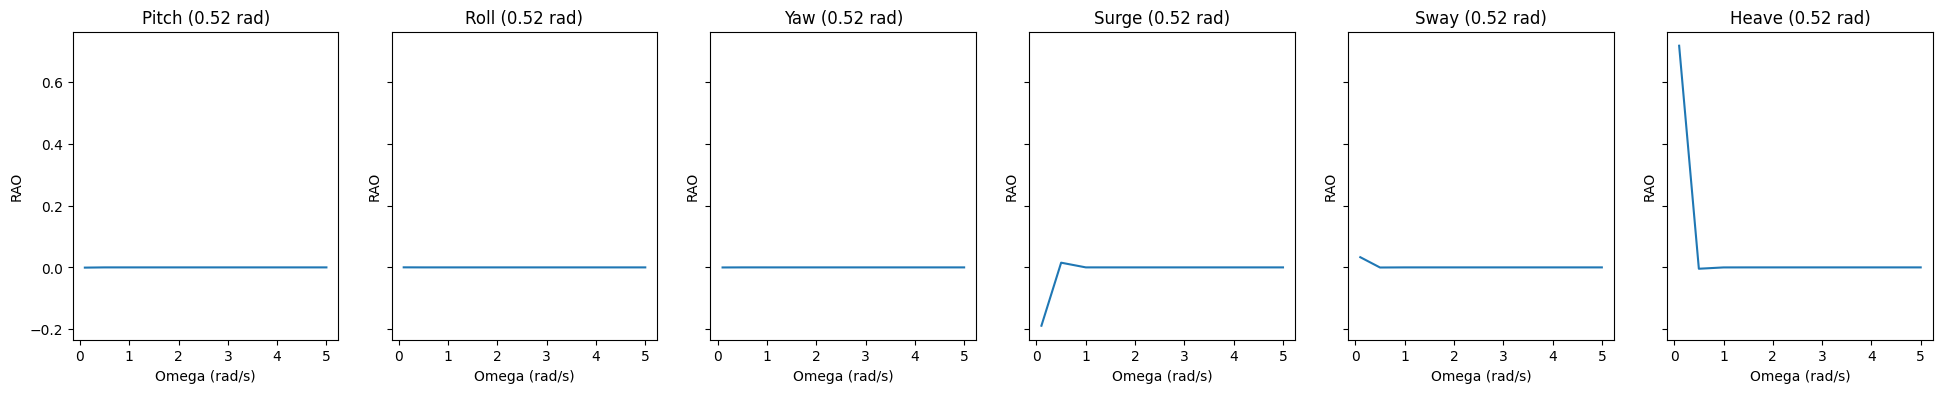

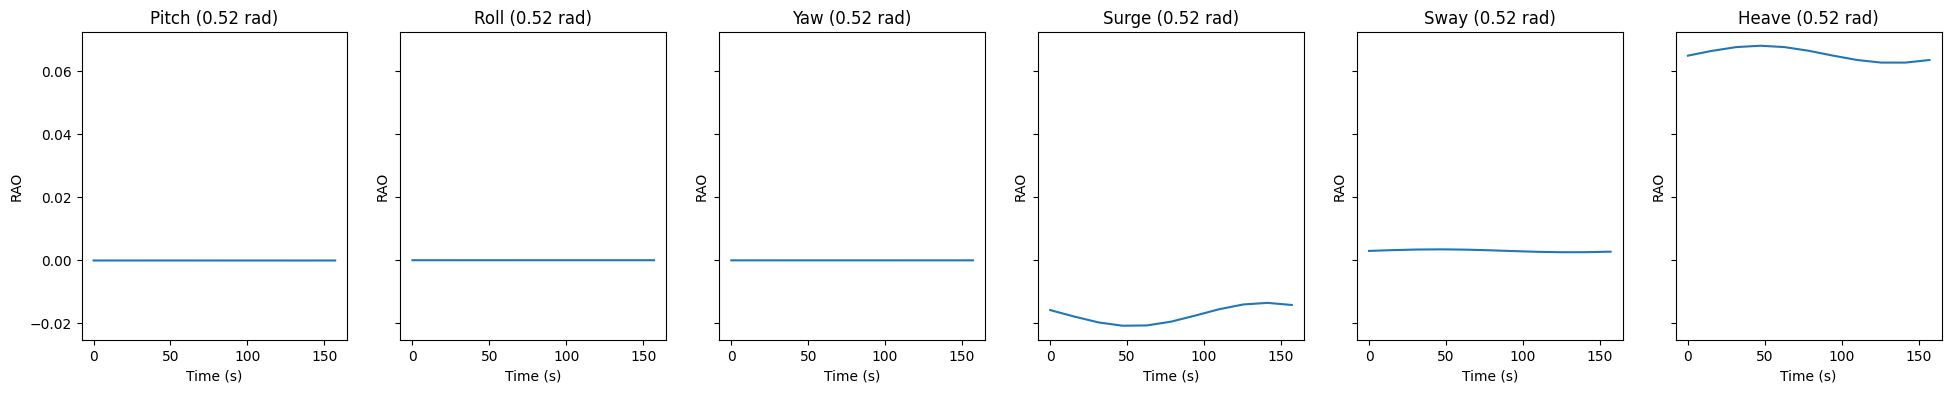

In [5]:
# wave_dirs = [0, np.pi/12, np.pi/6, np.pi/2, np.pi]
wave_dir = np.pi/6
plot_rao_freq(
    [ "Pitch", "Roll", "Yaw", "Surge", "Sway", "Heave"],
    wave_dir=wave_dir,
    tol=1e-3
)
plot_rao_time(
    [ "Pitch","Roll", "Yaw", "Surge", "Sway", "Heave"],
    wave_dir=wave_dir,
    tol=1e-3
)